In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import h5py
import random


with h5py.File("gdrive/My Drive/FDL project/dataset/background_for_training.h5", 'r') as file:
    data = file['Particles'][:]
    n_dataset_elements = data.shape[0]

print(data.shape)

(13451915, 19, 4)


## Standard scaler
$$
z_i = \frac{x_i - \bar{x}}{\delta x}
$$

where $\bar{x}$ is the mean and $\delta x$ is the Standard Deviation of the dataset

In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def scaler(data):
    data_scaled = np.zeros_like(data)

    for i in range(data.shape[2]):
        scaler = StandardScaler()
        data_feat = data[:, :, i].reshape(-1, 1)
        scaler.fit(data_feat)

        data_scaled[:, :, i] = scaler.transform(data_feat).reshape(data.shape[0], 19)

    return data_scaled

data_scaled = scaler(data)

In [9]:
from sklearn.model_selection import train_test_split

test_size=0.1
val_size=0.2

train_val_data, test_data = train_test_split(data_scaled, test_size=test_size, random_state=42)

val_relative_size = val_size / (1 - test_size)
train_data, val_data = train_test_split(train_val_data, test_size=val_relative_size, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (9416340, 19, 4)
Validation shape: (2690383, 19, 4)
Test shape: (1345192, 19, 4)


## Network

In [ ]:
import keras
import tensorflow as tf

dropout_rate = 0.3
regularizer_rate = 1e-4

embedding_dim = 32
patch_size = (1, 4)
n_patch = 19
n_heads = 4

inputs = keras.Input(shape=(19, 4))

# Positional Encoding
pos = tf.range(start=0, limit=n_patch, delta=1)
pos_embedding = keras.layers.Embedding(input_dim=n_patch, output_dim=embedding_dim)(pos)

input_enbedding = keras.layers.Dense(embedding_dim)(inputs)
x = input_enbedding + pos_embedding

# ------------------ Encoder ------------------
for _ in range(2):
    # Attention
    attention = keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim)(x, x)
    attention = keras.layers.Dropout(dropout_rate)(attention)

    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + attention) # --> Residual connection (Sum)

    # FFN
    ffn = keras.layers.Dense(embedding_dim * 4, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
    ffn = keras.layers.LeakyReLU()(ffn)
    ffn = keras.layers.Dense(embedding_dim, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(ffn)
    ffn = keras.layers.Dropout(dropout_rate)(ffn)

    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn) # --> Residual connection (Sum)

# ------------------ Bottleneck ------------------
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dense(19 * embedding_dim)(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Reshape((19, embedding_dim))(x)

# ------------------ Decoder ------------------
for _ in range(2):
    # Attention
    attention = keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=embedding_dim)(x, x)
    attention = keras.layers.Dropout(dropout_rate)(attention)

    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + attention) # --> Residual connection (Sum)

    # FF
    ffn = keras.layers.Dense(embedding_dim * 4, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(x)
    ffn = keras.layers.LeakyReLU()(ffn)
    ffn = keras.layers.Dense(embedding_dim, kernel_regularizer=keras.regularizers.l2(regularizer_rate))(ffn)
    ffn = keras.layers.Dropout(dropout_rate)(ffn)

    x = keras.layers.LayerNormalization(epsilon=1e-6)(x + ffn) # --> Residual connection (Sum)

x = keras.layers.Dense(4)(x)
x = keras.layers.LeakyReLU()(x)

outputs = x

net = keras.Model(inputs, outputs)
net.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 19, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 19, 32)    │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 19, 32)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 19, 32)    │     16,800 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 19, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 19, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 19, 32)    │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 19, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 19, 128)   │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 19, 32)    │      4,128 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 19, 32)    │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 19, 32)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 19, 32)    │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 19, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 19, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 19, 32)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 19, 32)    │         64 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 19, 128)   │      4,224 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 19, 128)   │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 257,796 (1007.02 KB)

 Trainable params: 257,796 (1007.02 KB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


# Compile
net.compile(
    loss=keras.losses.mean_squared_error,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3)
 )

# Training
history = net.fit(
    train_data,
    train_data,
    validation_data=(val_data, val_data),
    epochs=100,
    batch_size=512,
    shuffle=True,
    callbacks=[reduce_lr, early_stopping]
)

net.save_weights("gdrive/My Drive/FDL project/Trasformers.weights.h5")

Epoch 1/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 369s 19ms/step - loss: 0.0368 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 2/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 337s 18ms/step - loss: 9.5361e-04 - val_loss: 2.4634e-04 - learning_rate: 0.0010
Epoch 3/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 336s 18ms/step - loss: 4.9255e-04 - val_loss: 2.5567e-04 - learning_rate: 0.0010
Epoch 4/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 334s 18ms/step - loss: 9.3898e-04 - val_loss: 1.1497e-04 - learning_rate: 0.0010
Epoch 5/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 330s 18ms/step - loss: 5.4338e-04 - val_loss: 1.3519e-04 - learning_rate: 0.0010
Epoch 6/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 330s 18ms/step - loss: 6.4143e-04 - val_loss: 7.6302e-05 - learning_rate: 0.0010
Epoch 7/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 328s 18ms/step - loss: 4.0491e-04 - val_loss: 6.5956e-05 - learning_rate: 0.0010
Epoch 8/100
18392/18392 ━━━━━━━━━━━━━━━━━━━━ 329s 18ms/step - loss: 2.2716e-04 - val_loss: 1.1922e-04 - learning_rate: 0.0010


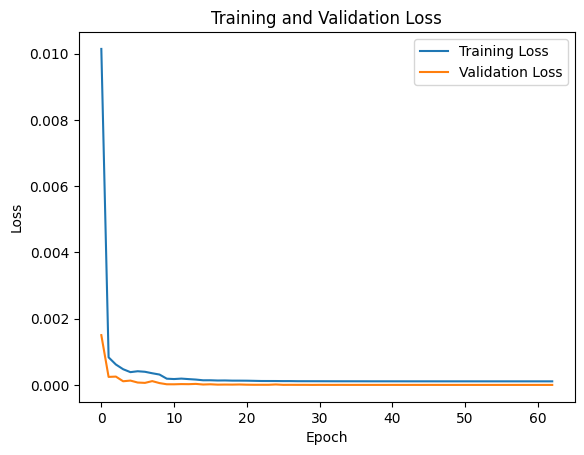

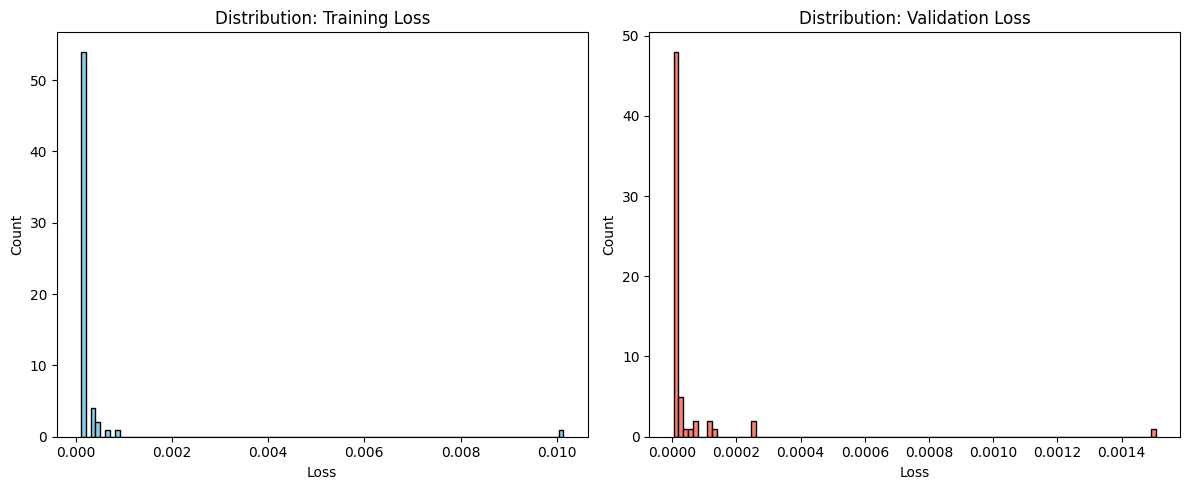

In [ ]:
import matplotlib.pyplot as plt

def visualize_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


def visualize_loss_pdf(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].hist(loss, bins=100, color='skyblue', edgecolor='black')
    axes[0].set_title('Distribution: Training Loss')
    axes[0].set_xlabel('Loss')
    axes[0].set_ylabel('Count')

    axes[1].hist(val_loss, bins=100, color='salmon', edgecolor='black')
    axes[1].set_title('Distribution: Validation Loss')
    axes[1].set_xlabel('Loss')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

visualize_loss(history)
visualize_loss_pdf(history)

# Data Analysis

## Function to visualize the results

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc


def loss_eventXevent(y_true, y_rec, c_p_t=1, c_eta=1, c_phi=1, zero_pt = -3.65475940e-01, zero_eta = 2.74188967e-04, zero_phi = -7.03800890e-05, step=0.001):
    """
    Calculates and visualizes the loss for each particle type (MET, electron, muon, jet) by plotting histograms of their losses.

    param: y_true, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_properties) for predicted data
    """
    MET_loss = []
    e_loss = []
    mu_loss = []
    jet_loss = []

    total_loss = []
    N = y_true.shape[0]

    for true, pred in zip(y_true, y_rec):
        #MET
        for true_particle, pred_particle in zip(true[0:1], pred[0:1]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                MET_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
        # e
        for true_particle, pred_particle in zip(true[1:5], pred[1:5]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                e_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)

        # mu
        for true_particle, pred_particle in zip(true[5:9], pred[5:9]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                mu_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)

        # jet
        for true_particle, pred_particle in zip(true[9:], pred[9:]):
            # print(true_particle.shape, pred_particle.shape)
            if true_particle[0] > zero_pt - step and true_particle[0] < zero_pt + step and true_particle[1] > zero_eta - step and true_particle[1] < zero_eta + step and true_particle[2] > zero_phi - step and true_particle[2] < zero_phi + step:
                continue
            else:
                p_t_loss = np.abs(true_particle[0] - pred_particle[0])
                eta_loss = (true_particle[1] - pred_particle[1])**2
                phi_loss = (true_particle[2] - pred_particle[2])**2
                jet_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)
                total_loss.append((c_p_t * p_t_loss + c_eta * eta_loss + c_phi * phi_loss)/N)

    return MET_loss, e_loss, mu_loss, jet_loss, total_loss


def propertis_division(data):
    """
    Divides the input data into properties for MET, electrons, muons, and jets.
    """
    MET_p_t, MET_eta, MET_phi = data[:, 0, 0], data[:, 0, 1], data[:, 0, 2]
    e_p_t, e_eta, e_phi = data[:, 1:5, 0], data[:, 1:5, 1], data[:, 1:5, 2]
    mu_p_t, mu_eta, mu_phi = data[:, 5:9, 0], data[:, 5:9, 1], data[:, 5:9, 2]
    jet_p_t, jet_eta, jet_phi = data[:, 9:, 0], data[:, 9:, 1], data[:, 9:, 2]

    return (MET_p_t, MET_eta, MET_phi, e_p_t, e_eta, e_phi, mu_p_t, mu_eta, mu_phi, jet_p_t, jet_eta, jet_phi)


def visualize_results(y_true, y_rec):
    """
    Visualizes the results by plotting the true and reconstructed properties of particles.

    param: y_true, numpy array of shape (n_samples, n_particles, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_particles, n_properties) for reconstructed data
    """
    MET_p_t_true, MET_eta_true, MET_phi_true, e_p_t_true, e_eta_true, e_phi_true, mu_p_t_true, mu_eta_true, mu_phi_true, jet_p_t_true, jet_eta_true, jet_phi_true = propertis_division(y_true)
    MET_p_t_rec, MET_eta_rec, MET_phi_rec, e_p_t_rec, e_eta_rec, e_phi_rec, mu_p_t_rec, mu_eta_rec, mu_phi_rec, jet_p_t_rec, jet_eta_rec, jet_phi_rec = propertis_division(y_rec)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].scatter(jet_p_t_true, jet_p_t_rec, color="red", label=r"$jet$")
    ax[0].scatter(mu_p_t_true, mu_p_t_rec, color="purple", label=r"$\mu$")
    ax[0].scatter(e_p_t_true, e_p_t_rec, color="green", label=r"$e$")
    ax[0].scatter(MET_p_t_true, MET_p_t_rec, color="blue", label=r"$\nu$")
    ax[0].set_xlabel('Original data')
    ax[0].set_ylabel('Reconstructed data')
    ax[0].set_title(r'$p_T$')
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ax[1].scatter(jet_eta_true, jet_eta_rec, color="red", label=r"$jet$")
    ax[1].scatter(mu_eta_true, mu_eta_rec, color="purple", label=r"$\mu$")
    ax[1].scatter(e_eta_true, e_eta_rec, color="green", label=r"$e$")
    ax[1].scatter(MET_eta_true, MET_eta_rec, color="blue", label=r"$\nu$")
    ax[1].set_xlabel('Original data')
    ax[1].set_ylabel('Reconstructed data')
    ax[1].set_title(r'$\eta$')
    ax[1].legend(loc="lower right")
    ax[1].grid(True)

    ax[2].scatter(jet_phi_true, jet_phi_rec, color="red", label=r"$jet$")
    ax[2].scatter(mu_phi_true, mu_phi_rec, color="purple", label=r"$\mu$")
    ax[2].scatter(e_phi_true, e_phi_rec, color="green", label=r"$e$")
    ax[2].scatter(MET_phi_true, MET_phi_rec, color="blue", label=r"$\nu$")
    ax[2].set_xlabel('Original data')
    ax[2].set_ylabel('Reconstructed data')
    ax[2].set_title(r'$\phi$')
    ax[2].legend(loc="lower right")
    ax[2].grid(True)


def residues_analysis(y_true, y_rec, n_bin=200):
    """
    Visualizes the distribution of residues for each property.

    param: y_true, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_properties) for reconstructed data
    """
    MET_p_t_true, MET_eta_true, MET_phi_true, e_p_t_true, e_eta_true, e_phi_true, mu_p_t_true, mu_eta_true, mu_phi_true, jet_p_t_true, jet_eta_true, jet_phi_true = propertis_division(y_true)
    MET_p_t_rec, MET_eta_rec, MET_phi_rec, e_p_t_rec, e_eta_rec, e_phi_rec, mu_p_t_rec, mu_eta_rec, mu_phi_rec, jet_p_t_rec, jet_eta_rec, jet_phi_rec = propertis_division(y_rec)

    MET_p_t_res = MET_p_t_true - MET_p_t_rec
    MET_eta_res = MET_eta_true - MET_eta_rec
    MET_phi_res = MET_phi_true - MET_phi_rec

    e_p_t_res = e_p_t_true - e_p_t_rec
    e_eta_res = e_eta_true - e_eta_rec
    e_phi_res = e_phi_true - e_phi_rec

    mu_p_t_res = mu_p_t_true - mu_p_t_rec
    mu_eta_res = mu_eta_true - mu_eta_rec
    mu_phi_res = mu_phi_true - mu_phi_rec

    jet_p_t_res = jet_p_t_true - jet_p_t_rec
    jet_eta_res = jet_eta_true - jet_eta_rec
    jet_phi_res = jet_phi_true - jet_phi_rec

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].hist([jet_p_t_res.flatten(), mu_p_t_res.flatten(), e_p_t_res.flatten(), MET_p_t_res], bins=n_bin, color=["red", "purple", "green", "blue"], histtype="step", linewidth=2, label=[r"$jet$", r"$\mu$", r"$e$", r"$\nu$"])
    ax[0].set_xlabel(r'$p_T^{true} - p_T^{predict}$')
    ax[0].set_ylabel('Count')
    ax[0].set_yscale('log')
    ax[0].set_title(r'$p_T$')
    ax[0].legend(loc="upper left")
    ax[0].grid(True)

    ax[1].hist([jet_eta_res.flatten(), mu_eta_res.flatten(), e_eta_res.flatten(), MET_eta_res], bins=n_bin, color=["red", "purple", "green", "blue"], histtype="step", linewidth=2, label=[r"$jet$", r"$\mu$", r"$e$", r"$\nu$"])
    ax[1].set_xlabel(r'$\eta^{true} - \eta^{predict}$')
    ax[1].set_ylabel('Count')
    ax[1].set_yscale('log')
    ax[1].set_title(r'$\eta$')
    ax[1].legend(loc="upper right")
    ax[1].grid(True)

    ax[2].hist([jet_phi_res.flatten(), mu_phi_res.flatten(), e_phi_res.flatten(), MET_phi_res], bins=n_bin, color=["red", "purple", "green", "blue"], histtype="step", linewidth=2, label=[r"$jet$", r"$\mu$", r"$e$", r"$\nu$"])
    ax[2].set_xlabel(r'$\phi^{true} - \phi^{predict}$')
    ax[2].set_ylabel('Count')
    ax[2].set_yscale('log')
    ax[2].set_title(r'$\phi$')
    ax[2].legend(loc="upper right")
    ax[2].grid(True)

    plt.tight_layout()
    plt.show()


def visualize_loss_eventXevent(total_loss, MET_loss=None, e_loss=None, mu_loss=None, jet_loss=None, n_bin=200):
    """
    Visualizes the distribution of loss for each particle type (MET, electron, muon, jet) by plotting histograms of their losses.

    param: y_true, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec, numpy array of shape (n_samples, n_properties) for predicted
    param: n_bin, number of bins for the histograms
    """
    if MET_loss is None and e_loss is None and mu_loss is None and jet_loss is None:
        plt.figure(figsize=(7,5))
        plt.hist(total_loss, bins=n_bin, color="blue")
        plt.xlabel(r'Loss')
        plt.ylabel('Count')
        plt.yscale('log')
        plt.xscale('log')
        plt.title(r'Total loss')

    else:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))
        if jet_loss is not None:
            ax[0].hist(jet_loss, bins=n_bin, color="red", histtype="step", linewidth=2, label=r"$jet$")
        if mu_loss is not None:
            ax[0].hist(mu_loss, bins=n_bin, color="purple", histtype="step", linewidth=2, label=r"$\mu$")
        if e_loss is not None:
            ax[0].hist(e_loss, bins=n_bin, color="green", histtype="step", linewidth=2, label=r"$e$")
        if MET_loss is not None:
            ax[0].hist(MET_loss, bins=n_bin, color="blue", histtype="step", linewidth=2, label=r"$\nu$")
        ax[0].set_xlabel(r'Loss')
        ax[0].set_ylabel('Count')
        ax[0].set_yscale('log')
        ax[0].set_xscale('log')
        ax[0].set_title(r'Loss')
        ax[0].legend(loc="upper right")
        ax[0].grid(True)

        ax[1].hist(total_loss, bins=n_bin, color="blue")
        ax[1].set_xlabel(r'Loss')
        ax[1].set_ylabel('Count')
        ax[1].set_yscale('log')
        ax[1].set_xscale('log')
        ax[1].set_title(r'Total loss')
        ax[1].grid(True)

    plt.tight_layout()
    plt.show()


def loss_eventXevent_comparison(background_loss, newphysics_loss: list, newphysics_names: list, n_bin=200):
    """
    Visualizes the distribution of loss for each particle type (MET, electron, muon, jet) by plotting histograms of their losses.

    param: y_true_background, numpy array of shape (n_samples, n_properties) for true data
    param: y_rec_background, numpy array of shape (n_samples, n_properties) for predicted
    param: y_true_newphysics, list of numpy arrays of shape (n_samples, n_properties) for true data
    param: y_rec_newphysics, list of numpy arrays of shape (n_samples, n_properties) for predicted
    param: newphysics_names, list of strings for the names of the newphysics datasets
    param: n_bin, number of bins for the histograms
    """
    plt.figure(figsize=(10,5))
    for i in range(len(newphysics_loss)):
        plt.hist(newphysics_loss[i], bins=n_bin, histtype="step", linewidth=2, label=newphysics_names[i])
    plt.hist(background_loss, bins=int(n_bin/4), histtype="step", linewidth=2, label="background")
    plt.xlabel(r'Loss')
    plt.ylabel('Count')
    plt.yscale('log')
    # plt.xscale('log')
    plt.title(r'Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def ROC_curves(loss_background, newphysics_loss: list, newphysics_names: list):
    loss_background = np.array(loss_background)
    for i in range(len(newphysics_loss)):
        newphysics_loss[i] = np.array(newphysics_loss[i])

    bsm_losses = {new_ph: loss for new_ph, loss in zip(newphysics_names, newphysics_loss)}

    # Plot ROC curves
    plt.figure(figsize=(8, 6))

    for label, bsm_loss in bsm_losses.items():
        # Combine SM and BSM loss arrays
        y_true = np.concatenate([
            np.zeros(len(loss_background)),    # 0 for SM
            np.ones(len(bsm_loss))  # 1 for BSM
        ])
        y_scores = np.concatenate([loss_background, bsm_loss])

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')

    # Plot random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for BSM Detection (Autoencoder)')
    plt.legend(loc='lower right', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Network weights loading


In [ ]:
net.load_weights("gdrive/My Drive/FDL project/weights/Trasformers.weights.h5")

## True  data vs Reconstructed data
### Scatter plot for each property


15625/15625 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step


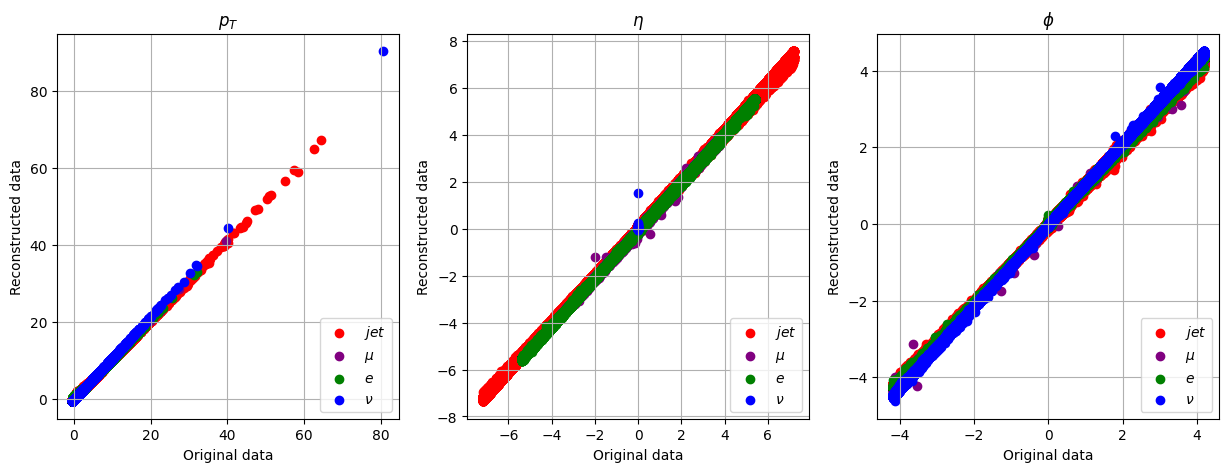

In [ ]:
# train_rec = net.predict(train_data)
test_rec = net.predict(test_data)

# visualize_results(train_data, train_rec)
visualize_results(test_data, test_rec)

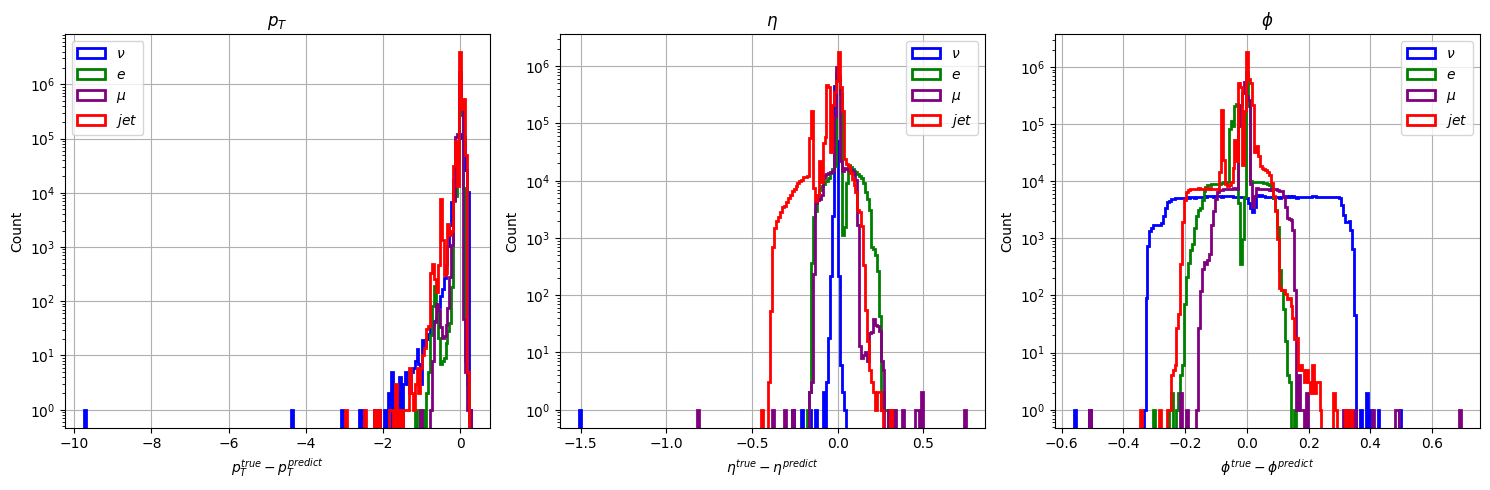

In [ ]:
residues_analysis(test_data, test_rec)

### Loss computation for batchsize = 1
$$
\mathcal{L}_j = \frac{1}{N_{event}}\bigg[|p_{Tj}^{true} - p_{Tj}^{predict}| + (\eta^{true}_j - \eta^{predict}_j)^2 + (\phi^{true}_j - \phi^{predict}_j)^2\bigg]
$$

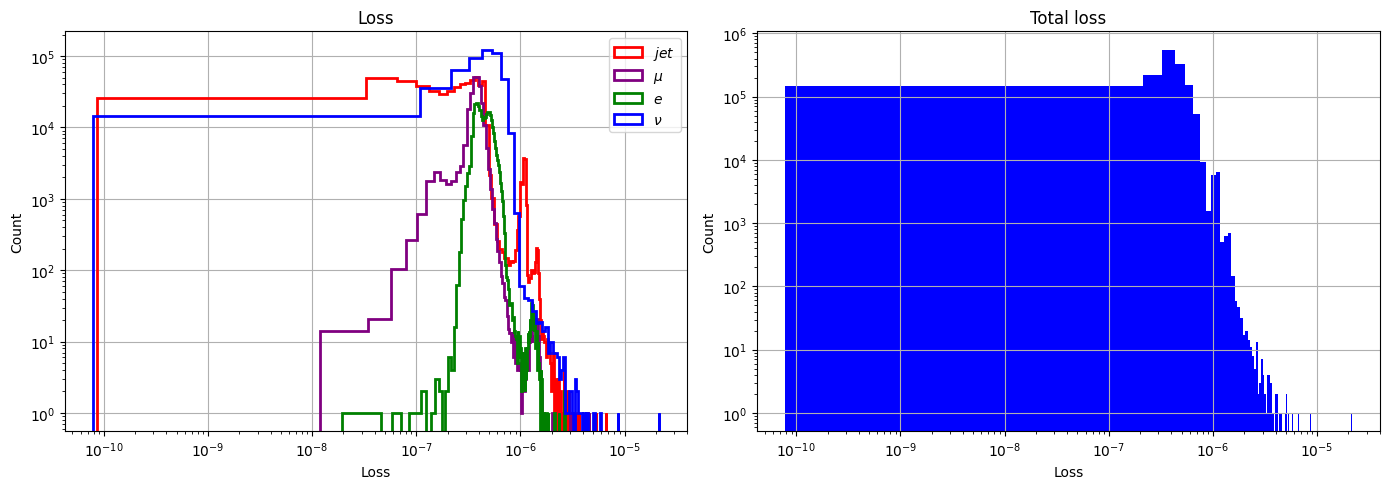

In [ ]:
MET_loss, e_loss, mu_loss, jet_loss, loss = loss_eventXevent(test_data, test_rec)
visualize_loss_eventXevent(loss, MET_loss, e_loss, mu_loss, jet_loss)

# Simulated data BSM

## $h^0\rightarrow\tau\tau\,$ dataset analysis


21603/21603 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step


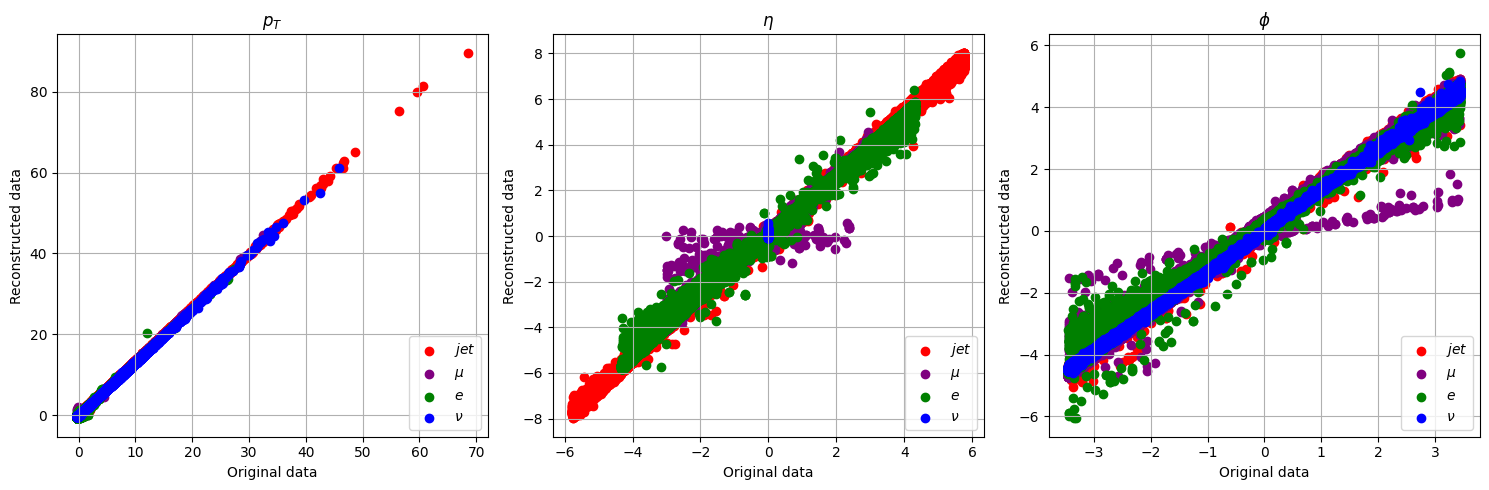

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/hToTauTau_13TeV_PU20_filtered.h5", 'r') as file:
    h_tt_po = file['Particles'][:]

h_tt = scaler(h_tt_po)

h_tt_rec = net.predict(h_tt)
visualize_results(h_tt, h_tt_rec)
file.close()

## $h^+\rightarrow\tau\nu\,$ dataset analysis


23759/23759 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step


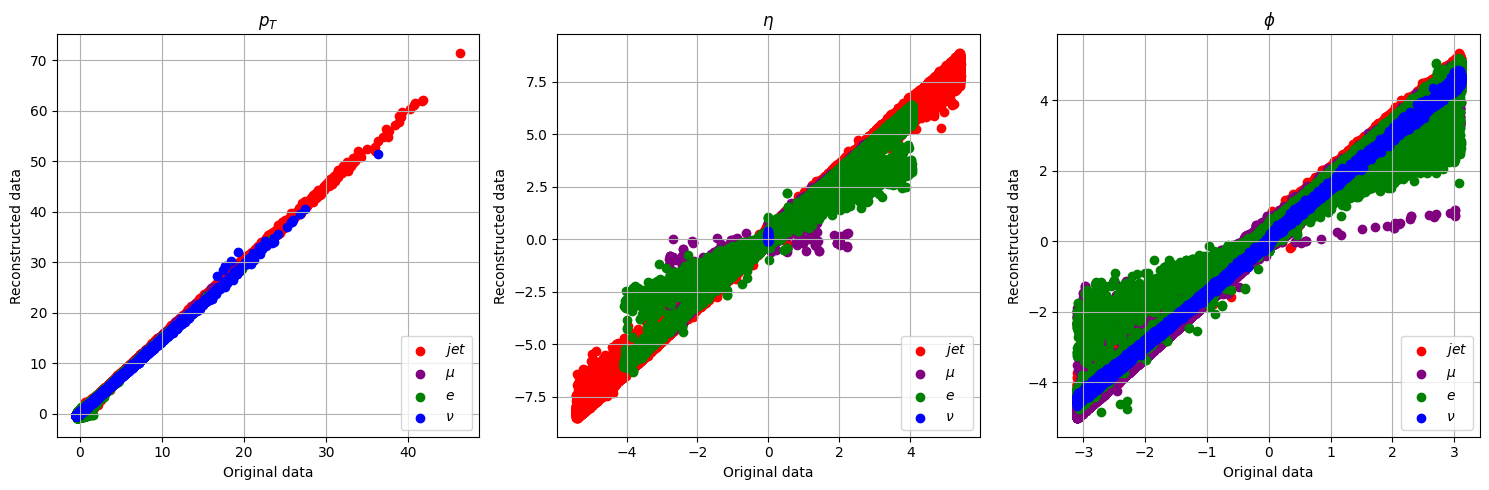

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/hChToTauNu_13TeV_PU20_filtered.h5", 'r') as file:
    h_tnu_po = file['Particles'][:]

h_tnu = scaler(h_tnu_po)

h_tnu_rec = net.predict(h_tnu)
visualize_results(h_tnu, h_tnu_rec)
file.close()

## $A\rightarrow 4l\,$ dataset analysis


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


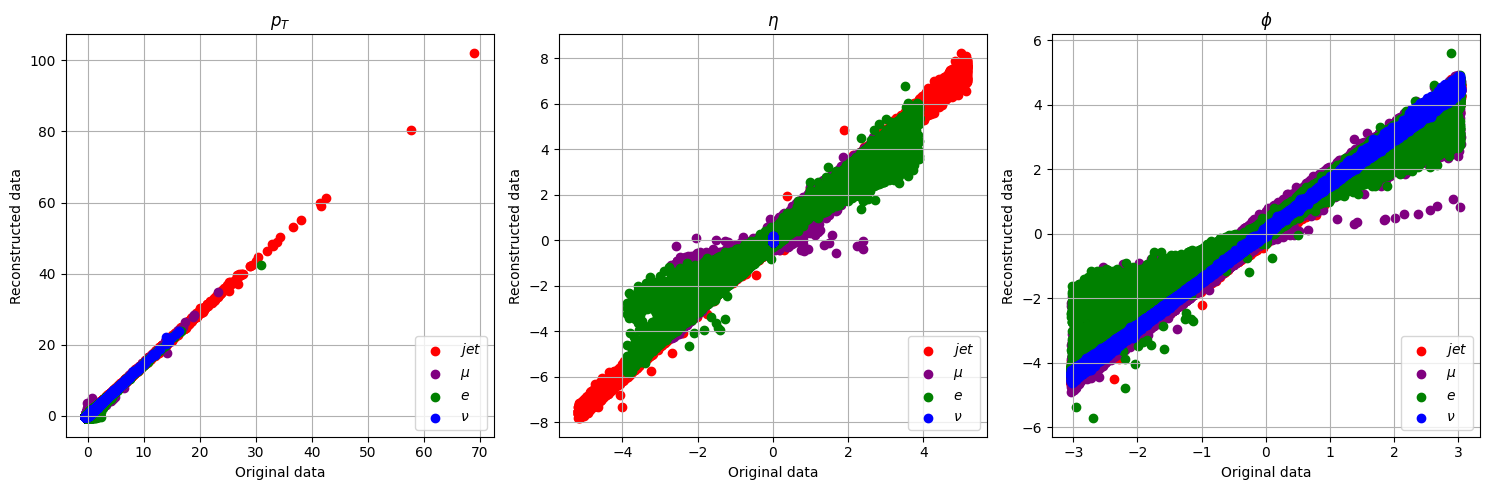

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/Ato4l_lepFilter_13TeV_filtered.h5", 'r') as file:
    A_4l_po = file['Particles'][:]

A_4l = scaler(A_4l_po)

A_4l_rec = net.predict(A_4l)
visualize_results(A_4l, A_4l_rec)
file.close()

## $LQ\rightarrow b\tau\,$ dataset analysis


10642/10642 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step


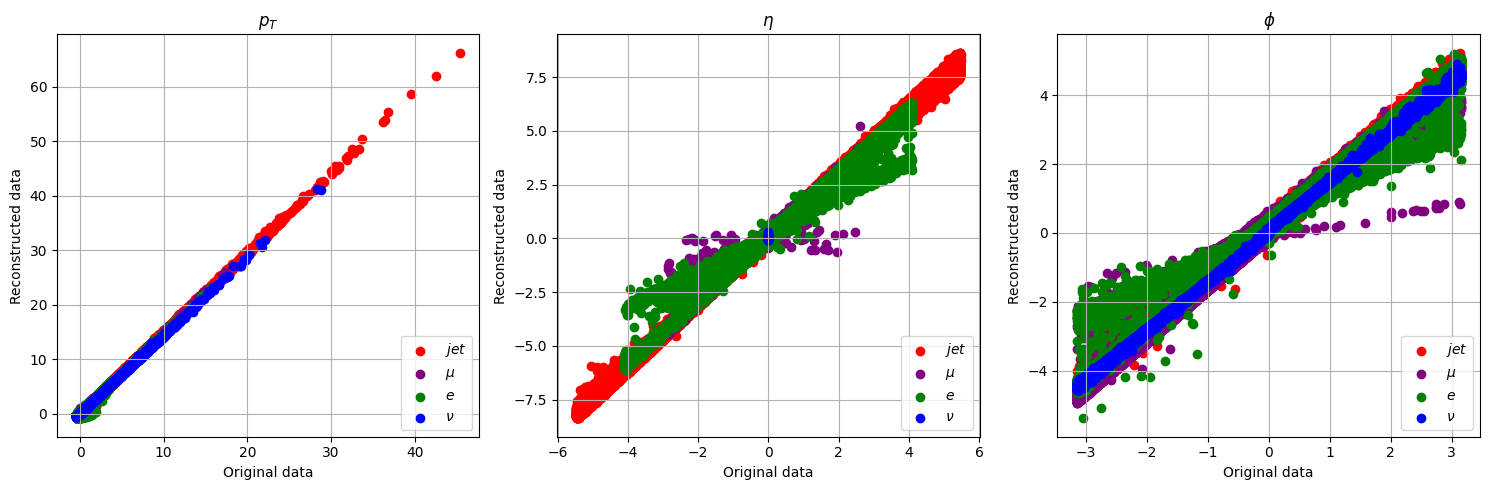

In [ ]:
with h5py.File("gdrive/My Drive/FDL project/dataset/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5", 'r') as file:
    LQ_bt_po = file['Particles'][:]

LQ_bt = scaler(LQ_bt_po)

LQ_bt_rec = net.predict(LQ_bt)
visualize_results(LQ_bt, LQ_bt_rec)
file.close()

## Recap

In [ ]:
_, _, _, _, loss_h_tt = loss_eventXevent(h_tt, h_tt_rec, zero_pt=-3.91916608e-01, zero_eta=8.42306028e-04, zero_phi=2.08138452e-04)
_, _, _, _, loss_h_tnu = loss_eventXevent(h_tnu, h_tnu_rec, zero_pt=-4.25901880e-01, zero_eta=-4.01769465e-04, zero_phi=-3.43055755e-04)
_, _, _, _, loss_A_4l = loss_eventXevent(A_4l, A_4l_rec, zero_pt=-4.28734457e-01, zero_eta=-1.03627494e-03, zero_phi=3.69865426e-04)
_, _, _, _, loss_LQ_bt = loss_eventXevent(LQ_bt, LQ_bt_rec, zero_pt=-4.71797178e-01, zero_eta=9.31079858e-04, zero_phi=2.75312937e-04)

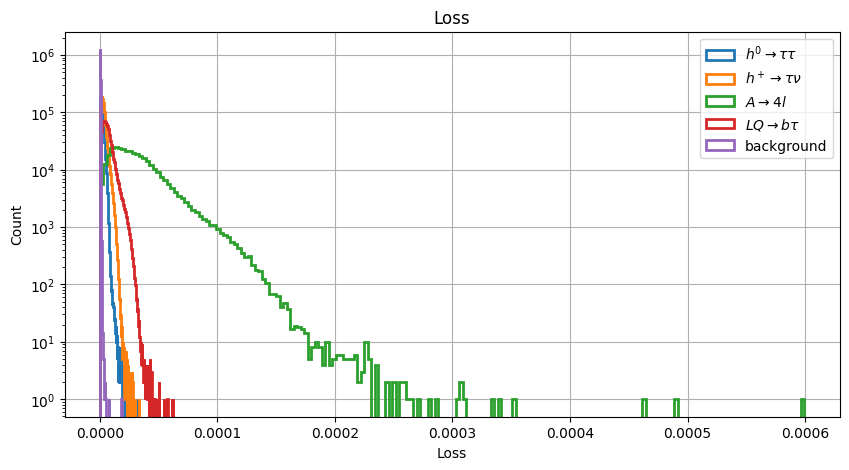

In [ ]:
loss_eventXevent_comparison(loss, [loss_h_tt, loss_h_tnu, loss_A_4l, loss_LQ_bt],
  [r"$h^0\rightarrow\tau\tau$", r"$h^+\rightarrow\tau\nu$", r"$A\rightarrow 4l$", r"$LQ\rightarrow b\tau$"])

## ROC curves

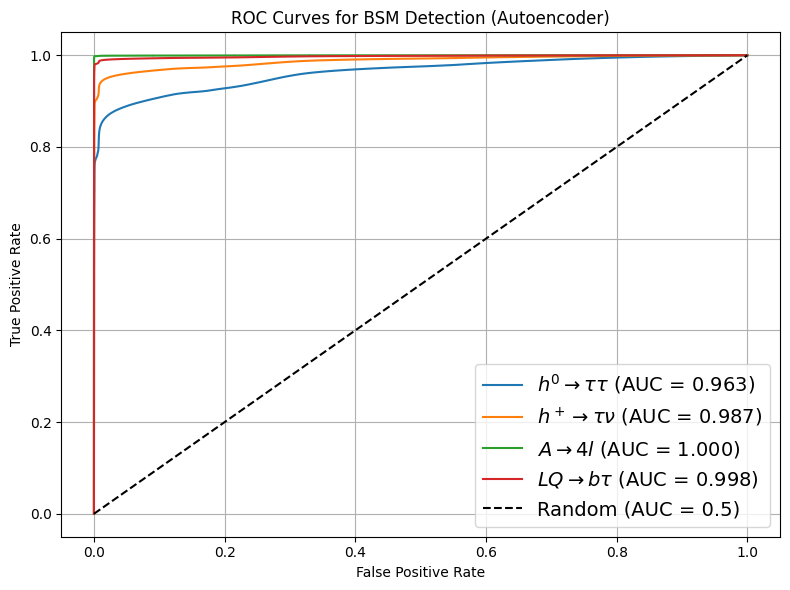

In [ ]:
ROC_curves(loss, [loss_h_tt, loss_h_tnu, loss_A_4l, loss_LQ_bt],
  [r"$h^0\rightarrow\tau\tau$", r"$h^+\rightarrow\tau\nu$", r"$A\rightarrow 4l$", r"$LQ\rightarrow b\tau$"])